# Análisis de Autos Usados

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from IPython.display import display

In [2]:
csv_path = os.path.join('..','datasets','raw','data.csv')
df = pd.read_csv(csv_path)
df.sample(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
1637,Chevrolet,Aveo,2009,regular unleaded,107.0,4.0,MANUAL,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,34,27,1385,15365
1480,Chevrolet,Astro Cargo,2005,regular unleaded,190.0,6.0,AUTOMATIC,rear wheel drive,3.0,NaN,Large,Cargo Minivan,20,15,1385,22930
844,Saab,9-3,2010,premium unleaded (recommended),207.0,4.0,AUTOMATIC,front wheel drive,4.0,Luxury,Compact,Wagon,27,19,376,37020
9021,GMC,Savana,2014,flex-fuel (unleaded/E85),280.0,8.0,AUTOMATIC,rear wheel drive,3.0,Flex Fuel,Midsize,Passenger Van,17,11,549,34160
9333,GMC,Sierra 1500,2015,flex-fuel (unleaded/E85),285.0,6.0,AUTOMATIC,rear wheel drive,2.0,Flex Fuel,Large,Regular Cab Pickup,24,18,549,33595
8102,Dodge,RAM 250,1993,regular unleaded,180.0,6.0,MANUAL,rear wheel drive,2.0,NaN,Large,Regular Cab Pickup,16,11,1851,2000
8472,Suzuki,Reno,2006,regular unleaded,126.0,4.0,AUTOMATIC,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,28,19,481,16299
5589,Lexus,GS 450h,2016,premium unleaded (required),338.0,6.0,AUTOMATIC,rear wheel drive,4.0,"Luxury,Performance,Hybrid",Midsize,Sedan,34,29,454,63080
7529,Nissan,Pathfinder,2016,regular unleaded,260.0,6.0,AUTOMATIC,four wheel drive,4.0,Crossover,Large,4dr SUV,26,19,2009,43300
6470,Land Rover,LR4,2016,premium unleaded (required),340.0,6.0,AUTOMATIC,four wheel drive,4.0,Luxury,Midsize,4dr SUV,19,15,258,50400


In [3]:
len(df)

11914

In [4]:
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

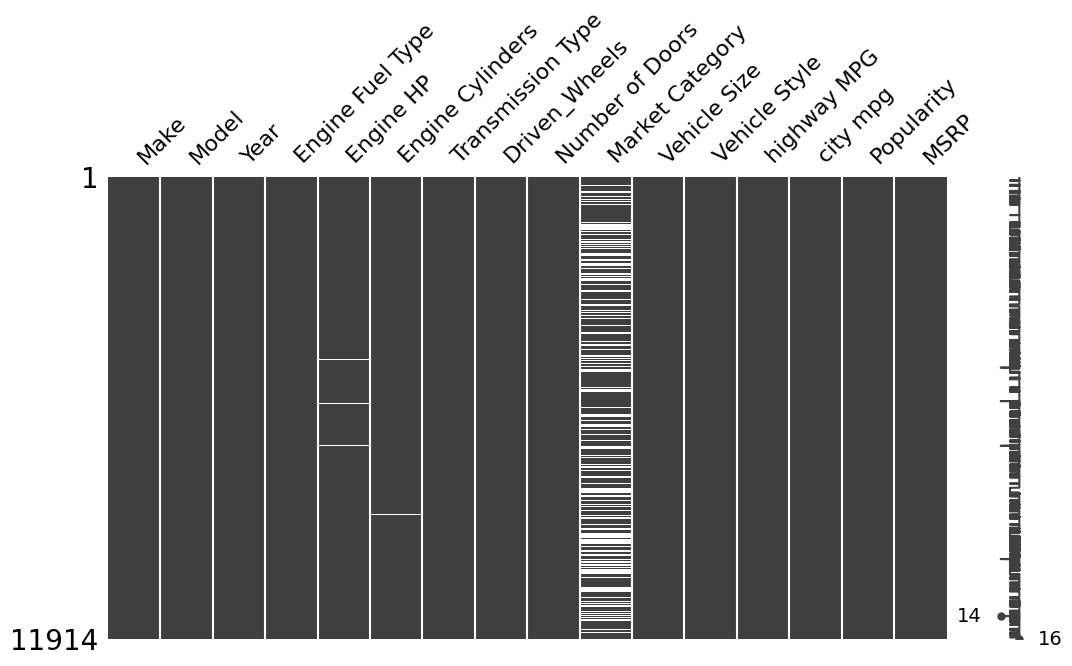

In [5]:
msno.matrix(df, figsize=(12,6))
plt.show()

In [6]:
# Valores nulos
nulls = df.isnull().sum()
nulls

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [7]:
#my_variables = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
cars = df.copy()

# Lowercase the column names and replace spaces with underscores
cars.columns = cars.columns.str.lower().str.replace(' ','_')
# Lista de la variables categóricas
categorical = list(cars.dtypes[cars.dtypes == 'object'].index)
# Lista de las variables numéricas
numerical = list(cars.dtypes[cars.dtypes != 'object'].index)


for feature in categorical:
    cars[feature] = cars[feature].str.lower().str.replace(' ', '_')
    
cars.sample(5)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
5432,volkswagen,golf_sportwagen,2015,diesel,150.0,4.0,automated_manual,front_wheel_drive,4.0,diesel,compact,wagon,42,31,873,25695
8613,volkswagen,routan,2010,regular_unleaded,251.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,passenger_minivan,25,17,873,38600
10681,ford,transit_connect,2017,flex-fuel_(unleaded/e85),169.0,4.0,automatic,front_wheel_drive,4.0,NaN,compact,cargo_minivan,27,20,5657,25425
5149,infiniti,g37_coupe,2010,premium_unleaded_(recommended),330.0,6.0,automatic,rear_wheel_drive,2.0,"luxury,performance",midsize,coupe,27,19,190,37500
6530,buick,lucerne,2009,flex-fuel_(unleaded/e85),227.0,6.0,automatic,front_wheel_drive,4.0,flex_fuel,large,sedan,26,17,155,33120


In [8]:
# Creación de una nueva variables objetivo

# Valor de la media de msrp
msrp_mean = cars['msrp'].mean()

# Precio por debajo de la media
cars['above_average'] = (cars['msrp'] <= msrp_mean).astype(int)

# Distribución
cars['above_average'].value_counts()

above_average
1    8645
0    3269
Name: count, dtype: int64

In [9]:
# Cantidad de valores únicos por variable(categórica)
cars[categorical].nunique()

make                  48
model                914
engine_fuel_type      10
transmission_type      5
driven_wheels          4
market_category       71
vehicle_size           3
vehicle_style         16
dtype: int64

In [10]:
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
number_of_doors,11908.0,3.436093,0.881315,2.0,2.0,4.0,4.00,4.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0
above_average,11914.0,0.725617,0.446222,0.0,0.0,1.0,1.00,1.0


In [11]:
df_train_full, df_test = train_test_split(cars, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)

y_train = df_train.msrp.values
y_val = df_val.msrp.values
y_test = df_test.msrp.values

del df_train['msrp']
del df_val['msrp']

In [12]:
# Lista los valores únicos de las variables categóricas
for feature in categorical:
    if cars[feature].nunique() <= 16:
        if cars[feature].isnull().any():
            nulls = cars[feature].isnull().sum()
            print(f"{feature.upper()} ---  {nulls} valores nulos.")
        else :
            print(feature.upper())

        print("--------------------------------------------------")    
        for i in df_train_full[feature].unique():
            print(f"* {i}")
        print()
    

ENGINE_FUEL_TYPE ---  3 valores nulos.
--------------------------------------------------
* premium_unleaded_(required)
* flex-fuel_(unleaded/e85)
* premium_unleaded_(recommended)
* regular_unleaded
* diesel
* flex-fuel_(premium_unleaded_required/e85)
* electric
* flex-fuel_(premium_unleaded_recommended/e85)
* flex-fuel_(unleaded/natural_gas)
* nan
* natural_gas

TRANSMISSION_TYPE
--------------------------------------------------
* automatic
* manual
* automated_manual
* direct_drive
* unknown

DRIVEN_WHEELS
--------------------------------------------------
* rear_wheel_drive
* all_wheel_drive
* front_wheel_drive
* four_wheel_drive

VEHICLE_SIZE
--------------------------------------------------
* compact
* large
* midsize

VEHICLE_STYLE
--------------------------------------------------
* coupe
* extended_cab_pickup
* convertible
* 4dr_hatchback
* 4dr_suv
* sedan
* passenger_minivan
* 2dr_suv
* wagon
* passenger_van
* crew_cab_pickup
* regular_cab_pickup
* convertible_suv
* 2dr_hatc

In [13]:
# Entradas con valor 'nan' en variable 'engine_fuel_type'
df_train_full[df_train_full.engine_fuel_type.isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,above_average
11321,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,17199,1
11322,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,20199,1
11323,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,18499,1


In [14]:
# Entradas con valor 'unknown' en variable 'trasnmission_type'
df_train_full[df_train_full.transmission_type == "unknown"]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,above_average
6158,gmc,jimmy,1999,regular_unleaded,190.0,6.0,unknown,rear_wheel_drive,2.0,NaN,compact,2dr_suv,19,14,549,2182,1
8053,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
6174,gmc,jimmy,2000,regular_unleaded,190.0,6.0,unknown,four_wheel_drive,2.0,NaN,compact,2dr_suv,18,14,549,2578,1
4691,pontiac,firebird,2000,regular_unleaded,305.0,8.0,unknown,rear_wheel_drive,2.0,"hatchback,performance",midsize,2dr_hatchback,23,15,210,6175,1
8048,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
8047,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
6160,gmc,jimmy,1999,regular_unleaded,190.0,6.0,unknown,four_wheel_drive,2.0,NaN,compact,2dr_suv,19,14,549,2317,1
8046,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
8051,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
6368,chrysler,le_baron,1993,regular_unleaded,100.0,4.0,unknown,front_wheel_drive,2.0,NaN,compact,convertible,24,18,1013,2000,1


## Feature Engineering

In [15]:
def map_engine_fuel_type(fuel_type):
    for key, values in fuel_types.items():
        if fuel_type in values:
            return key
    return None  # Si no se encuentra ninguna coincidencia, puedes manejarla como desees

fuel_types = {
    'premium': ['premium_unleaded_(required)', 'premium_unleaded_(recommended)'],
    'regular': ['regular_unleaded'],
    'diesel': ['diesel'],
    'flex': [
        'flex-fuel_(unleaded/e85)',
        'flex-fuel_(premium_unleaded_required/e85)',
        'flex-fuel_(premium_unleaded_recommended/e85)',
        'flex-fuel_(unleaded/natural_gas)'
    ],
    'electric': ['electric'],
    'gas': ['natural_gas'],
    'other': ['nan']
}

# Utiliza la función map_engine_fuel_type para mapear los valores en 'engine_fuel_type'
df_train_full['engine_fuel_type'] = df_train_full['engine_fuel_type'].map(map_engine_fuel_type)


In [16]:
# Relleno valores pérdidos con 0
cars[['engine_hp','engine_cylinders']] = cars[['engine_hp','engine_cylinders']].fillna(value=0)

# Millas por galón promedio
df_train_full['mpg_avg'] = df_train_full['highway_mpg'] + df_train_full['city_mpg'] / 2

# Reemplaza 'unknown' por 'manual' en variable 'transmission_type'
df_train_full['transmission_type'] = df_train_full.transmission_type.str.replace('unknown', 'manual')

categorical_features = ['make', 'model', 'transmission_type',]

numerical_features = ['year', 'engine_hp', 'engine_cylinders']


## Feature Importance

### Mutual Information

In [17]:
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    """
    Calcula el puntaje de información mutua de las variables categóricas 
    con respecto a 'above_average'
    """
    return mutual_info_score(series, df_train_full.above_average)


df_train_full.dropna(inplace=True)
mi_scores = df_train_full[categorical].apply(calculate_mi)
mi_scores.sort_values(ascending=False)

model                0.513725
market_category      0.316894
make                 0.252473
driven_wheels        0.109750
vehicle_style        0.107899
engine_fuel_type     0.098431
vehicle_size         0.037558
transmission_type    0.010340
dtype: float64

### Risk Ratio

In [18]:
global_mean = df_train_full.above_average.mean()
global_mean

0.628300714507611

In [19]:
manual_transmission = df_train_full[df_train_full.transmission_type == 'manual'].above_average.mean()
automatic_transmission = df_train_full[df_train_full.transmission_type == 'automatic'].above_average.mean()
manual_transmission, automatic_transmission

(0.7510980966325037, 0.6043307086614174)

### Correlation Coefficient

In [20]:
compact_size = df_train_full[df_train_full.vehicle_size == 'compact'].above_average.mean()
mid_size = df_train_full[df_train_full.vehicle_size == 'midsize'].above_average.mean()
large_size = df_train_full[df_train_full.vehicle_size == 'large'].above_average.mean()
compact_size

0.7704985578903997

In [21]:
df_train_full[numerical].corrwith(df_train_full.above_average).sort_values(ascending=True)

engine_hp          -0.651421
engine_cylinders   -0.484300
msrp               -0.447022
year               -0.253018
popularity          0.002554
number_of_doors     0.089807
highway_mpg         0.217546
city_mpg            0.269277
dtype: float64

In [22]:
df_train_full[numerical].corrwith(df_train_full.msrp).sort_values(ascending=True)

city_mpg           -0.274550
highway_mpg        -0.254041
number_of_doors    -0.182947
popularity         -0.052338
year                0.131272
engine_cylinders    0.589899
engine_hp           0.654511
msrp                1.000000
dtype: float64

## Preprocessing

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

imputer = SimpleImputer(strategy='median')

ct = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), ['engine_hp', 'engine_cylinders']),
        ('ohe', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)


model = LogisticRegression(solver='liblinear')

pipeline = Pipeline([
    ('preprocessing', ct),
    ('model', model)])

pipeline.fit(df_train, y_train)

score = pipeline.score(X_val, y_val)
score

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [ ]:
# Importa la clase Dict vectorizer para convertir datos categóricos en formato dicciionario a formato numérico
#dv = DictVectorizer(sparse=False)

# Convierte el conjunto de entrenamiento en un formato de lista de diccionarios
#train_dict = df_train_transformed.to_dict(orient='records')
#X_train = dv.fit_transform(train_dict)

# Crea un modelo de regresión logística
model = LogisticRegression(solver='liblinear')

# Entrena el modelo de regresión logística
model.fit(df_train_transformed, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
y_pred

X_train

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

prob = (y_pred >= .5).astype(int)
acc = accuracy_score(y_val, prob).round(1)
prec = precision_score(y_val, prob).round(1)
rec = recall_score(y_val, prob).round(1)

print(acc)
print(prec)
print(rec)


In [ ]:
thresholds = np.linspace(0, 1, 101)

accuracies = []
for t in thresholds:
    prob = y_pred >= t
    acc = accuracy_score(y_val, prob >= t)
    accuracies.append(acc)
    

plt.plot(thresholds, accuracies)

### Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")


plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

In [ ]:

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

In [ ]:
plt.plot(recalls, precisions, "g-")
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()